# Notebook for exploring data retrieved with filter sets.

## General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()

### Config file
Some of the scripts below pull common variables from a config file.  This is so in order to reduce redundancy and also facilitates running scripts outside of jupyter notebooks.  However, variables need to be able to be set in notebooks too, so the cell below deletes and then rewrites the config file according to what to you want for this notebook.

In [2]:
# Set variables in the following text string, not variable assignment below.
text = """#NOTE! this is overwritten by some notebooks, so update everywhere, if adding lines.
sp_id = 'bybcux0'
summary_name = 'cuckoo'
gbif_req_id = 'r001'
gbif_filter_id = 'GBIF_f2'
ebird_req_id = None
ebird_filter_id = None
evaluation = 'eval_gbif1'
workDir = '/Users/nmtarr/Documents/RANGES/'
codeDir = '/Users/nmtarr/Code/range_map_evaluation/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 150000
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + sp_id + '_occurrences.sqlite' # Name of species occurrence db.
"""
f = open('config.py', 'w')
f.write(text)
f.close()

import config
species_id = config.sp_id
summary_name = config.summary_name
request_id = config.gbif_req_id
filter_id = config.gbif_filter_id
inDir = config.inDir
outDir = config.outDir

In [3]:
connjup = sqlite3.connect('/users/nmtarr/documents/ranges/inputs/rng_eval_params.sqlite')
cursorjup = connjup.cursor()

## Species Concept

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts;").fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '4,5,6,7,8',
 'common_name': 'yellow-billed cuckoo',
 'detection_distance_meters': 200,
 'end_year': None,
 'error_tolerance': 40,
 'fws_id': None,
 'gap_id': 'bybcux',
 'gbif_id': '2496287',
 'geometry': None,
 'itis_tsn': '177831',
 'migratory': '1',
 'notes': 'Manually entered for use in development. ',
 'pad': 2,
 'scientific_name': 'Coccyzus americanus',
 'species_id': 'bybcux0',
 'start_year': None,
 'wintering_months': '11,12,1,2'}


## Filters

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("REQUEST FILTER SET")
print(df1.loc[0])

REQUEST FILTER SET
request_id                                 GBIF_r2
source                                        GBIF
lat_range                                    27,41
lon_range                                  -91,-75
years_range                              2000,2020
months_range                                  1,12
geoissue                                     False
coordinate                                    True
continent                            north_america
creator                                    N. Tarr
notes           Used in development, very liberal.
Name: 0, dtype: object


In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=connjup)
print("POST REQUEST FILTER SET")
print(df2.loc[0])

POST REQUEST FILTER SET
filter_id                                                                         GBIF_f2
source                                                                               GBIF
has_coordinate_uncertainty                                                              1
creator                                                                           N. Tarr
notes                         Used for development.  An open filter; does not remove a...
Name: 0, dtype: object


## Run Query

In [7]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__89%2Fbb%2F19%2F89bb19045ef553fdf3a05056b81618649e77e351 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__db%2Fb5%2F9a%2Fdbb59a7ae14e77d87bd9a6f527f91dd55e577628 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.xml
277 records exist


## Results

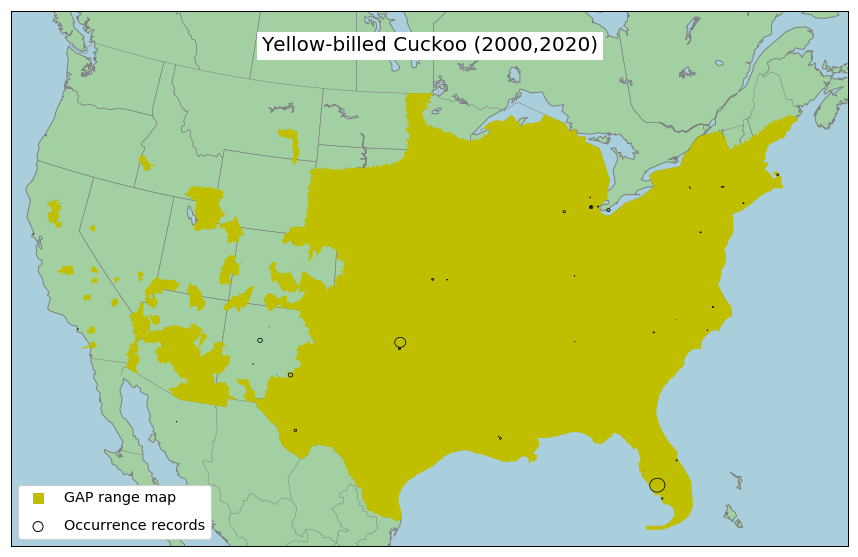

In [8]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="Yellow-billed Cuckoo ({0})".format(years)
functions.MapShapefilePolygons(map_these=[shp1, shp2], title=title)

### Where were records retrieved from?

In [9]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = cursorjup.execute("SELECT filter_sets FROM evaluations WHERE evaluation_id = 'eval_gbif1'").fetchone()[0]
filter_sets = filter_sets.split(",")

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### How many records made it through the filters?

In [10]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records made it through the filters")

125 records made it through the filters


### What years were represented in the data?

Text(0.5, 1.0, 'Occurrences per Year')

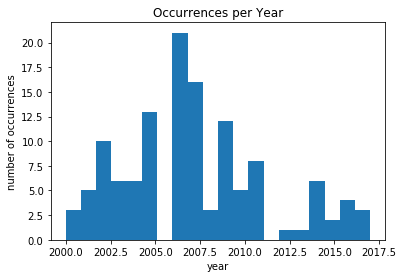

In [11]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_years, bins=20)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.title("Occurrences per Year")

### What months were represented in the data?

Text(0.5, 1.0, 'Occurrences per Month')

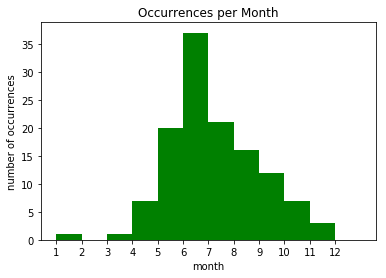

In [12]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### How many records had coordinate uncertainty values?

In [13]:
uncert_cnt = curs_occ.execute("SELECT COUNT(coordinateUncertaintyInMeters) FROM occurrences WHERE species_id = '{0}' AND coordinateUncertaintyInMeters >= 0".format(species_id)).fetchone()
print(str(uncert_cnt[0]) + " records with coordinate uncertainty values")

125 records with coordinate uncertainty values


### What is the distribution of coordinate uncertainty values?

Text(0.5, 1.0, 'Coordinate Uncertainty')

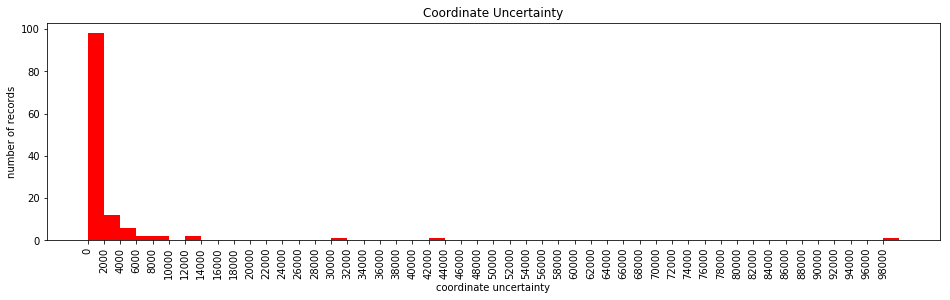

In [14]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

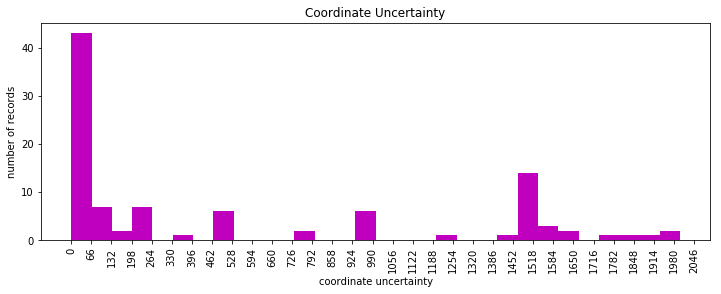

In [25]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### What geodetic datums other than WGS84 were present in the data?

In [16]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
datums = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    if occdict['geodeticDatum'] != 'WGS84':
        print("non-WGS84")
        datums.append(occdict['geodeticDatum'])
print((datums))

[]


### What issues were present in the data?

In [17]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
issues = set([])
for id in occ_ids:
    occdict = occurrences.get(key=id)
    issues = issues | set(occdict['issues'])
for x in list(issues):
    print(x)

RECORDED_DATE_MISMATCH
GEODETIC_DATUM_ASSUMED_WGS84
COORDINATE_REPROJECTED
COORDINATE_ROUNDED


### What were the bases of the records?

In [18]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
bases = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    BOR = occdict['basisOfRecord']
    if BOR == "" or BOR == None:
        bases.append("UNKNOWN")
    else:
        bases.append(BOR)
for x in list(set(bases)):
    print(x)

PRESERVED_SPECIMEN


### What institutions provided the records?

In [19]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
by = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    try:
        who = occdict['institutionID']
        by.append(who)
    except:
        who = occdict['institutionCode']
        by.append(who)
for x in list(set(by)):
    print(x)

UWYMV
urn:lsid:biocol.org:col:34847
OMNH
http://biocol.org/urn:lsid:biocol:org:34802
urn:lsid:biocol.org:col:34925
b4640710-8e03-11d8-b956-b8a03c50a862
http://biocol.org/urn:lsid:biocol.org:col:34940
ROM
urn:lsid:biocol.org:col:35013
urn:lsid:biocol.org:col:34878
UMMZ
urn:lsid:biocol.org:col:34495
urn:lsid:biocol.org:col:35295
http://grbio.org/cool/i64g-wjcr
CAS
http://grbio.org/cool/iakn-125z
http://grbio.org/cool/nn0p-dxqs


### What data collections were included?

In [20]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
collecs = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    try:
        who = occdict['collectionCode']
        collecs.append(who)
    except:
        pass
for x in list(set(collecs)):
    print(x)

Orn
ORN
Bird
Birds
Bird specimens
birds


### Were there duplicate records?

In [21]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

11 records were duplicates based on xy coordinate and date-time


### What keys/fields were returned for the records?

In [22]:
dfkf = pd.read_csv(outDir + "fields_returned.csv", index_col='fields')
pprint.pprint(dfkf)

                                  included(n)  populated(n)
fields                                                     
acceptedScientificName                    277           277
acceptedTaxonKey                          277           277
accessRights                              191           191
associatedSequences                         1             1
basisOfRecord                             277           277
behavior                                   45            45
bibliographicCitation                      33            33
catalogNumber                             277           277
class                                     277           277
classKey                                  277           277
collectionCode                            277           277
collectionID                              142           142
continent                                 277           277
coordinateUncertaintyInMeters             125           125
country                                 

### Runtime

In [24]:
t2 = datetime.now()
print(t2 - t1)

0:03:35.062076
